Q. Can we identify users who have similar viewing habits and recommend anime based on these similarities?

To answer this I am trying to see if I can create cluster of users based on viewing attributes: Completed(Number of animes completed), Rewatched(Number of animes rewatched), and Watching(Number of animes a user is currently watching). Based on this clustering we can suggest anime to a user based on the animes being seen by the other users in the same cluster.

The algorithm being used now is HDBSCAN, it is a robust algorithm and works well when we do not know the number of clusters.

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

data = pd.read_csv('../../joined_datasets/joined_rating_dataset.csv')
cleaned_dataset = pd.read_csv("../../cleaned_datasets/users_details_dataset_cleaned.csv")
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5207686 entries, 0 to 5207685
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   user_id           int64  
 2   anime_id          int64  
 3   rating            int64  
 4   Gender            object 
 5   Location          object 
 6   Birthday_Date     object 
 7   Joined_Date       object 
 8   Age_Join          float64
 9   Episodes Watched  float64
 10  Age               float64
 11  Name              object 
 12  Genres            object 
 13  Type              object 
 14  Start Date        object 
 15  End Date          object 
 16  Studios           object 
 17  Source            object 
 18  Rank              object 
 19  Episodes          float64
 20  Episodes_Norm     float64
dtypes: float64(5), int64(4), object(12)
memory usage: 834.4+ MB


In [101]:
cleaned_dataset.info()
cleaned_dataset = cleaned_dataset.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41486 entries, 0 to 41485
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        41486 non-null  int64  
 1   Mal ID            41486 non-null  int64  
 2   Username          41486 non-null  object 
 3   Gender            40316 non-null  object 
 4   Birthday          41486 non-null  object 
 5   Location          41486 non-null  object 
 6   Joined            41486 non-null  object 
 7   Days Watched      41485 non-null  float64
 8   Mean Score        41485 non-null  float64
 9   Watching          41485 non-null  float64
 10  Completed         41485 non-null  float64
 11  On Hold           41485 non-null  float64
 12  Dropped           41485 non-null  float64
 13  Plan to Watch     41485 non-null  float64
 14  Total Entries     41485 non-null  float64
 15  Rewatched         41485 non-null  float64
 16  Episodes Watched  41485 non-null  float6

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


Standardized all data in data set

In [103]:

data_filtered = cleaned_dataset[['Mal ID', 'Completed', 'Rewatched', 'Watching']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_filtered_scaled = scaler.fit_transform(data_filtered[['Completed', 'Rewatched', 'Watching']])

# Adding the user_id back after scaling (to keep track of users)
data_filtered_scaled = pd.DataFrame(data_filtered_scaled, columns=['Completed', 'Rewatched', 'Watching'])


First pass with cluster size and samples.
We can see that there are many data with cluster as -1. This means that our data was not clustered correctly. We will need to update our inputs min_samples and min_cluster_size to reduce this.

In [105]:
import hdbscan

# Apply HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10, metric='euclidean')
data_filtered_scaled['Cluster'] = hdbscan_model.fit_predict(data_filtered_scaled)

# Add the cluster info back to the original data
cleaned_dataset['Cluster'] = data_filtered_scaled['Cluster']
cluster_counts = cleaned_dataset['Cluster'].value_counts()
print(cluster_counts)


Cluster
-1.0      16214
 774.0      374
 350.0      351
 204.0      277
 209.0      211
          ...  
 414.0        9
 92.0         9
 272.0        9
 52.0         9
 761.0        9
Name: count, Length: 980, dtype: int64


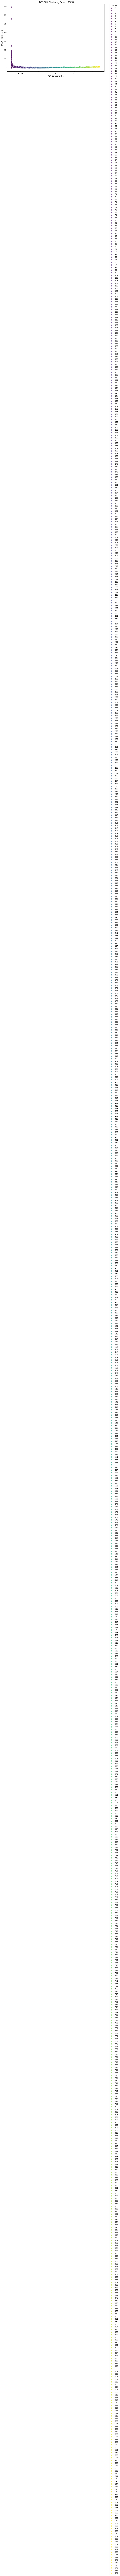

In [106]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_filtered_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data_filtered_scaled['Cluster'], palette="viridis", s=50, alpha=0.7, legend='full')
plt.title("HDBSCAN Clustering Results (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

Second pass with updated values of min_samples=3 and min_cluster_size=8 and for distance metric using manhattan instead of euclidean
The negative values have reduced quite a lot after this. ~40%

In [107]:
# Using updated values 3, 10, manhattan


hdbscan_model = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=8, metric='manhattan')
data_filtered_scaled['Cluster'] = hdbscan_model.fit_predict(data_filtered_scaled)

# Add the cluster info back to the original data
cleaned_dataset['Cluster'] = data_filtered_scaled['Cluster']

cluster_counts = cleaned_dataset['Cluster'].value_counts()
print(cluster_counts)


Cluster
-1.0       10182
 998.0       374
 765.0       351
 999.0       182
 1278.0      175
           ...  
 651.0         7
 1403.0        6
 1450.0        6
 1080.0        6
 1459.0        6
Name: count, Length: 1489, dtype: int64


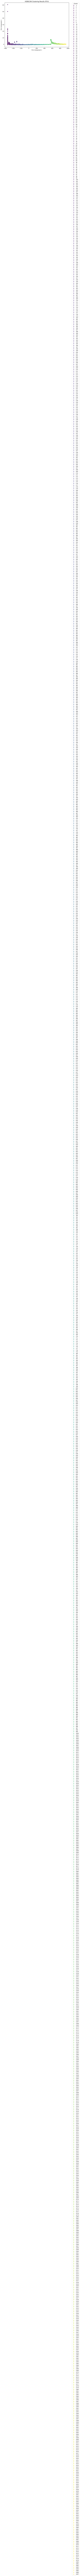

In [108]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_filtered_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data_filtered_scaled['Cluster'], palette="viridis", s=50, alpha=0.7, legend='full')
plt.title("HDBSCAN Clustering Results (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

Second pass with updated values of min_samples=3 and min_cluster_size=5 and for distance metric using manhattan instead of euclidean
The negative values have reduced quite a lot after this. ~30%

In [109]:



hdbscan_model = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=5, metric='manhattan')
data_filtered_scaled['Cluster'] = hdbscan_model.fit_predict(data_filtered_scaled)

# Add the cluster info back to the original data
cleaned_dataset['Cluster'] = data_filtered_scaled['Cluster']

cluster_counts = cleaned_dataset['Cluster'].value_counts()
print(cluster_counts)

Cluster
-1.0       6858
 1856.0     374
 1779.0     351
 1857.0     182
 345.0      175
           ... 
 565.0        4
 1054.0       4
 2394.0       4
 2014.0       4
 1841.0       3
Name: count, Length: 2398, dtype: int64


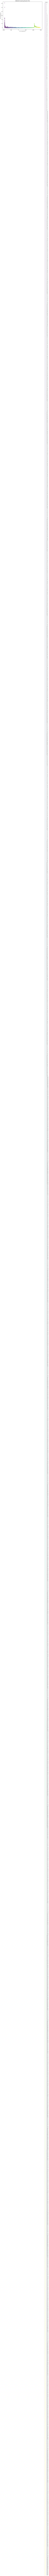

In [110]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_filtered_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data_filtered_scaled['Cluster'], palette="viridis", s=50, alpha=0.7, legend='full')
plt.title("HDBSCAN Clustering Results (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

I cannot reduce the size of the cluster or minimum samples anymore, so as last resort we'll add all the data with negative values to their respective closest clusters

In [112]:

import numpy as np
from sklearn.metrics.pairwise import manhattan_distances
data_filtered_scaled['Mal ID'] = cleaned_dataset['Mal ID']
cluster_centroids = data_filtered_scaled.groupby('Cluster').mean().values


distances = manhattan_distances(data_filtered_scaled.drop('Mal ID', axis=1), cluster_centroids)


outliers = data_filtered_scaled[data_filtered_scaled['Cluster'] == -1].index
for outlier in outliers:

    nearest_cluster = np.argmin(distances[outlier])
    data_filtered_scaled.at[outlier, 'Cluster'] = nearest_cluster


cleaned_dataset['Cluster'] = data_filtered_scaled['Cluster']

cluster_counts = cleaned_dataset['Cluster'].value_counts()
print(cluster_counts)

Cluster
2193.0    6864
1856.0     374
1779.0     351
1857.0     182
345.0      175
          ... 
1723.0       4
1197.0       4
1902.0       4
1812.0       4
1841.0       3
Name: count, Length: 2397, dtype: int64


In [113]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_filtered_scaled.drop('Mal ID', axis=1))

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data_filtered_scaled['Cluster'], palette="viridis", s=50, alpha=0.7, legend='full')
plt.title("HDBSCAN Clustering Results (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# With this we can get similar users and then recommend the top rated animes from these similar users